# Road User Classification
by Kuanchieh Peng

## Problem Statement
> Build a best feasible model that will be later used to classify road users in real time. The top priorities are: maximizing classification accuracy on unseen data and minimizing prediction speed.

## Steps

- **EDA & Preprocessing**
    - Cleaning
        - Handling outliers
        - Converting independent and dependent variables into desired data types
    - Transformation
        - Uninvariate displots and boxplots to spot skewness
    - Scaling
    - Checking Multicollinearity
        - Bivariate correlation heatmaps and pairplots to understand pairwise correlations
    - Checking Linear Separability
        - Training a hard margin linear SVC to test linear separability
- **Model Selection**
- **Evaluation Metric Selection**
- **Modeling**
    - Model Selection
    - Logistic Regression
    - Random Forest
- **Evaluation**
    - F-1.2 Score
    - ROC Curve
    - Prediction Speed

## Source of Data

"Mobile Accelerometer Car 12K" from Kaggle.

## Imports

In [78]:
# for preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# for modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.model_selection import RepeatedStratifiedKFold
import time

# for evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# for suppressing system warnings
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = RuntimeWarning)

In [19]:
df = pd.read_csv('vrudata.csv')
original_df = df.copy()

## Pipeline

In [20]:
class bold:
    start = '\033[1m'
    end   = '\033[0m'

def information(df):
    # Prints typically useful statistical information about given dataframe.
    print("This dataframe consists of ", df.shape[1], " columns and", df.shape[0], " rows.")
    print("This dataframe consists of ", df.isnull().sum().sum(), " null entires.")
    print("This dataframe consists of ", df[df.duplicated()].shape[0], " duplicate rows.")
    print(df[df['target'] == 1].shape[0], " rows belong to class target = 1.")
    print(df[df['target'] == 0].shape[0], " rows belong to class target = 0.")
    print("")
    print(bold.start, "Notable statistics of numeric features in this dataset:", bold.end)
    print("")
    print(df.describe())
    print("")
    print(bold.start, "Object type of features in this dataset:", bold.end)
    print("")
    df.info()
    
def dist_box(x, title = ''):
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (14.4, 7.2))
    for ax in axes:
        sns.kdeplot(x, shade = False, ax = ax)
        kdeline = ax.lines[0]
        xs = kdeline.get_xdata()
        ys = kdeline.get_ydata()
        if ax == axes[0]:
            middle = x.mean()
            sdev = x.std()
            left = middle - sdev
            right = middle + sdev
            ax.set_title('Mean and SD')
        else:
            left, middle, right = np.percentile(x, [25, 50, 75])
            ax.set_title('Median and Quartiles')
        ax.vlines(middle, 0, np.interp(middle, xs, ys), ls = ':')
        ax.fill_between(xs, 0, ys, alpha = 0.2)
        ax.fill_between(xs, 0, ys, where = (left <= xs) & (xs <= right), interpolate = True, alpha = 0.2)
    fig.suptitle(title, fontsize = 16)
    plt.show()
    
def three_d_scatter(df, target = 'target'):
    fig = plt.figure(figsize = (14.4, 10.8))
    ax = fig.add_subplot(111, projection = '3d')
    df_target1 = df[df[target] == 1]
    df_target0 = df[df[target] == 0]
    legend_properties = {}

    ax.scatter(df_target1['acc_x'], df_target1['acc_y'], df_target1['acc_z'], marker = 'x', label = 'Cars')
    ax.scatter(df_target0['acc_x'], df_target0['acc_y'], df_target0['acc_z'], marker = 'o', label = 'Non Cars')
    plt.legend(loc = 'best', prop = legend_properties)
    plt.show()

## EDA

In [21]:
df.head(3)

,acc_x,acc_y,acc_z,target
0,-0.113725,0.083797,9.654618,not car
1,-0.098162,0.087388,9.630676,not car
2,-0.099359,0.094571,9.645041,not car


### Cleaning

In [22]:
information(df)

This dataframe consists of  4  columns and 120000  rows.
This dataframe consists of  0  null entires.
This dataframe consists of  8186  duplicate rows.
0  rows belong to class target = 1.
0  rows belong to class target = 0.

 Notable statistics of numeric features in this dataset: 

               acc_x          acc_y          acc_z
count  120000.000000  120000.000000  120000.000000
mean       -0.354549       5.367115       6.729311
std         1.931744       3.420114       2.588606
min       -12.509735     -19.051361     -19.093689
25%        -1.116619       1.902695       4.829160
50%        -0.529119       6.922834       6.459327
75%        -0.092177       8.182184       9.212952
max        36.782090      13.737244      60.973206

 Object type of features in this dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   acc_x   120000 non-nu

- There are no missing values in the dataframe.
- The three features acc_x, acc_y, acc_z are in desired data type (float, instead of string like object).
- Notable statistic: The data has perfectly balanced classes.
- Our target variable is categorical; map it to values 0 and 1 using a label encoder.

In [23]:
encoder = LabelEncoder()
encoder.fit(df['target'])
df['target'] = encoder.transform(df['target'])
df.head(3)

,acc_x,acc_y,acc_z,target
0,-0.113725,0.083797,9.654618,1
1,-0.098162,0.087388,9.630676,1
2,-0.099359,0.094571,9.645041,1


### Transformation
- Use df.skew() to determine whether our features are skewed, meaning whether transformation is neeeded.
- Visualization using distplot-boxplot combined plots for better interpretability.

In [24]:
df.skew(axis = 0)

acc_x     5.031114
acc_y    -0.793934
acc_z    -0.329718
target    0.000000
dtype: float64

- acc_x has large skewness therefore needs transformation. Skewness of acc_y, acc_z are fine.

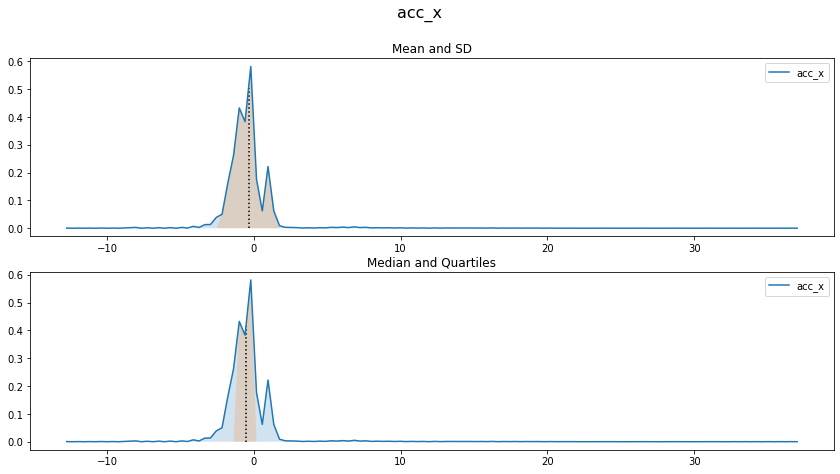

In [25]:
dist_box(df['acc_x'], 'acc_x')

- acc_x is right skewed. Perform log transformation on the data.

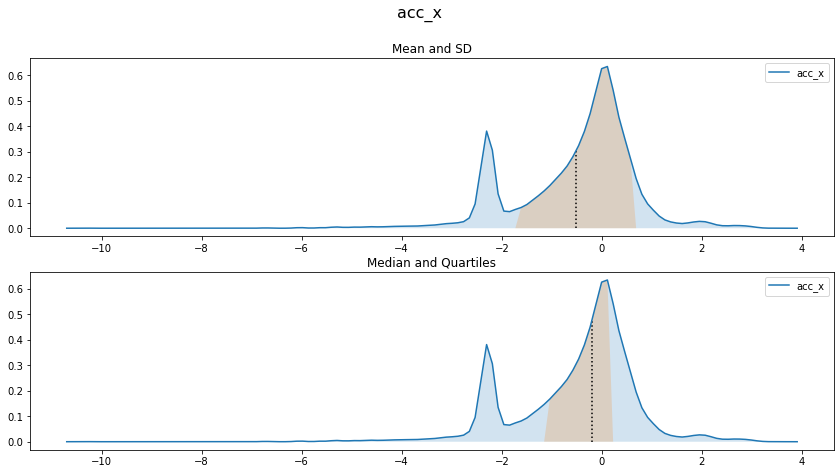

In [26]:
df['acc_x'] = np.log(abs(original_df['acc_x']))
dist_box(df['acc_x'], 'acc_x')

In [27]:
df.skew(axis = 0)

acc_x    -0.868861
acc_y    -0.793934
acc_z    -0.329718
target    0.000000
dtype: float64

- Skewness in acc_x is nonw acceptale and much better than before.

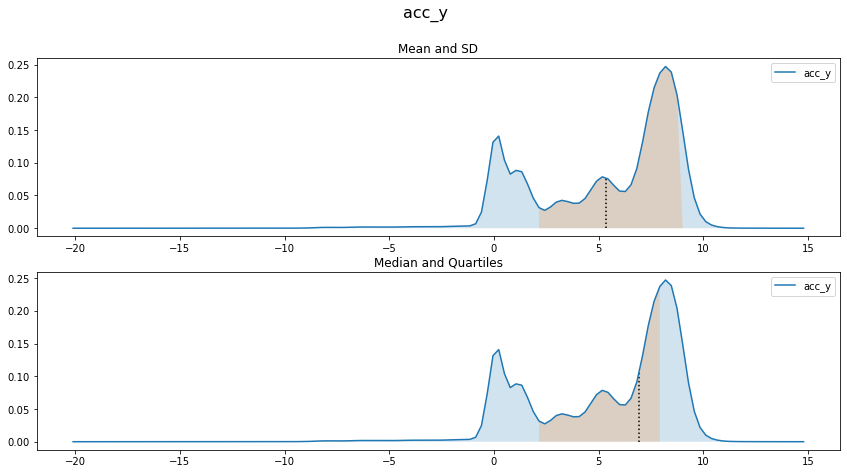

In [28]:
dist_box(df['acc_y'], 'acc_y')

- accy is only slgihtly (skew coefficient < 1) but obviously left skewed (apparently mean < median < mode).

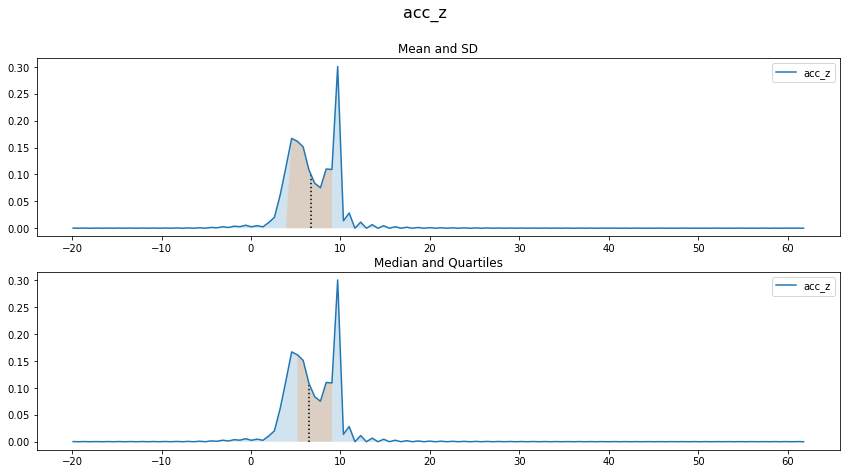

In [29]:
dist_box(df['acc_z'], 'acc_z')

### Scaling
- Our features are not normally distributed but has no outliers. Therefore, use min-max scaler.

In [30]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df.head(3)

,acc_x,acc_y,acc_z,target
0,0.587281,0.583592,0.359054,1.0
1,0.576771,0.583701,0.358755,1.0
2,0.577637,0.583920,0.358934,1.0


### Checking Multicollinearity

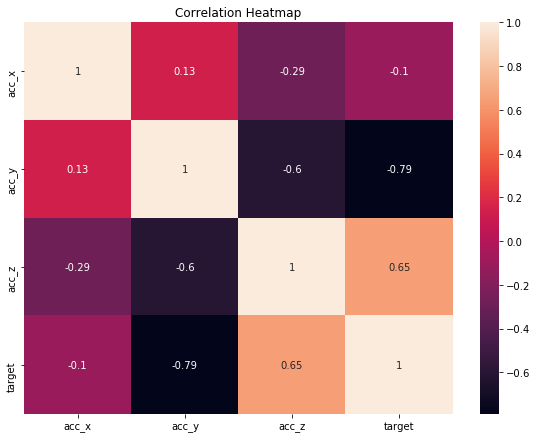

In [34]:
corr = df.corr()
plt.figure(figsize = (9.6, 7.2))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True)
plt.title("Correlation Heatmap")
plt.show()

- The correlation between acc_y and acc_z is -0.6, rather strong, meaning there is some multicollinearity in the dataset. Consider removing one of the two variables if using logistic regression.
- acc_y highly correlated to target variables. Reasonable explanation: cars can achieve much larger accelerations on forawrd-backward motions (which is the y-axis for accelerometer on phone, determined by how road users place phone) compared to pedestrains or bikers.

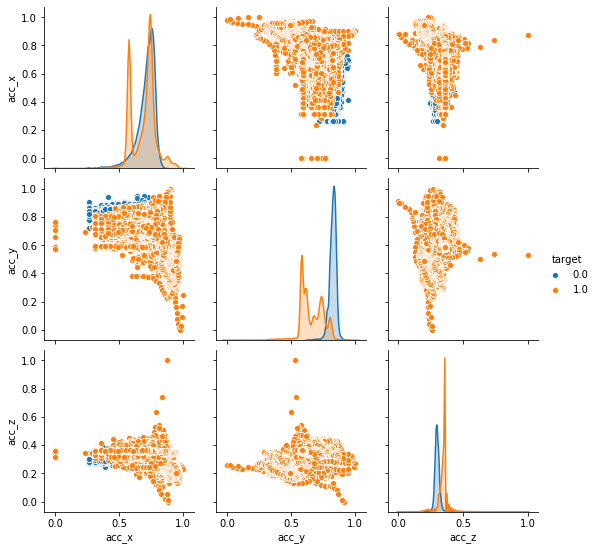

In [36]:
sns.pairplot(df, hue = 'target')
plt.show()

### Checking Linear Separability

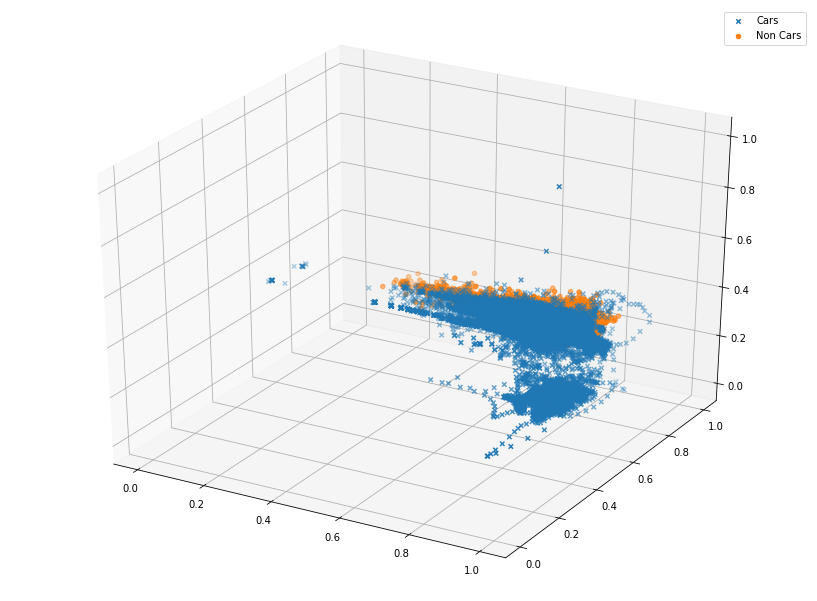

In [40]:
three_d_scatter(df, target = 'target')

- According to the 3-D graph above, data of the two classes might be linearly separable.
- In the following block, to determine whether the data is linearly separable, I trained a hard margin SVC with the data. If the training is able to find a margin for the hard margin SVM, the data is linearly separable; vice versa.
- I used a linear SVC with the regularization parameter C set to infinity for the hard margin SVC desired. For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. When C is set a infininty, we get a hard margin SVM.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df[{'acc_x', 'acc_y', 'acc_z'}],
                                                   df['target'],
                                                   test_size = 0.2,
                                                   random_state = 42)

In [91]:
svc = make_pipeline(StandardScaler(), LinearSVC(C = float('inf'), max_iter = 1000))
svc.fit(X_train, y_train)
print("Training accuracy:", svc.score(X_train, y_train))

Training accuracy: 0.9282395833333333


C:\Users\kuanc\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [94]:
print("Accuracy:", svc.score(X_test, y_test))

Accuracy: 0.927625


- The hard margin SVC found a margin and did not overfit. As a result, the data is linearly separable.

## Model Selection
We want to prioritize getting the best **classification accuracy on unknown data** and  **classification speed**. We can sacrafice training speed and interpretability of the model.

The entire dataset consists of **3 continuous feature columns, 1 categorical target column, and 120,000 rows**. There are no missing or questionable values in the dataset. The distribution of the transformed three variables are still slightly **skewed** left, right, and right in the order acc_x, acc_y, and acc_z. There are **no outliers** in any of the three. Data of the two classes are **linearly separable.**


As a result, logistic regression and random forest would be the best model choices for this project.

Then, since we have a large amount of data and care about limiting training time, consider using stochastic gradient descent to optimize our classifier.

## Evaluation Metric selection
- justification

## Logistic Regression

### Feature Selection
- Reminder: The correlation between acc_y and acc_z is -0.6. Might have to remove one of the two variables to make sure the model has little to no multicollinearity (one of the assumptions of logistic regression).

In [62]:
X_train, X_test, y_train, y_test = train_test_split(df[{'acc_x', 'acc_y', 'acc_z'}],
                                                   df['target'],
                                                   test_size = 0.2,
                                                   random_state = 42)

In [63]:
X_train['intercept'] = 1
logit = sm.Logit(y_train, X_train)
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.196124
         Iterations 9


In [64]:
X_train = X_train.drop('intercept', axis = 1)
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.717     
Dependent Variable: target           AIC:              37663.8374
Date:               2021-12-06 16:40 BIC:              37701.7258
No. Observations:   96000            Log-Likelihood:   -18828.   
Df Model:           3                LL-Null:          -66541.   
Df Residuals:       95996            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     9.0000                                       
-----------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
-----------------------------------------------------------------
acc_x          -0.2016   0.1851  -1.0894 0.2760  -0.5644   0.1611
acc_z          15.0144   0.9679  15.5127 0.0000  13.1174  16.9114
acc_y         -51.0029   0.5479 -93.0955 0.0000 -52.0766 -49.9291
intercept      35.0216   0.7070  49.5355 0.0000  33.6359  36.4073
=================================================================

"""

- acc_x has p-value of 0.276 > 0.05. Remove acc_x from logistic regression training.

### Fitting the Model

In [73]:
X_train_logit = X_train.drop('acc_x', axis = 1)
logit = LogisticRegression()
logit.fit(X_train_logit, y_train)

LogisticRegression()

In [95]:
print("Training accuracy:", logit.score(X_train_logit, y_train))

Training accuracy: 0.9288229166666667


In [97]:
X_test_logit = X_test.drop('acc_x', axis = 1)
y_pred = logit.predict(X_test.drop('acc_x', axis = 1))
start_time = time.time()
print("Accuracy:", logit.score(X_test_logit, y_test))
print("Speed: %s seconds" % (time.time() - start_time))

Accuracy: 0.929375
Speed: 0.005997657775878906 seconds


### Evaluation

In [165]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(confusion_matrix)

              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93     11799
         1.0       0.96      0.90      0.93     12201

    accuracy                           0.93     24000
   macro avg       0.93      0.93      0.93     24000
weighted avg       0.93      0.93      0.93     24000

[[11323   476]
 [ 1217 10984]]


- We consider precision as much as recall in this scenario. Therefore consider F1-score as our indicator.
    - The F1-score is 0.93.
- There are much more type I errors than type II errors (FP > FN; FP ~= 2 * FN).
- We have very high TPR. That is, it's very unlikely we misclassify an actual car as another type of road user for example pedestrians or bikers.

#### ROC Curve
- redundant maybe

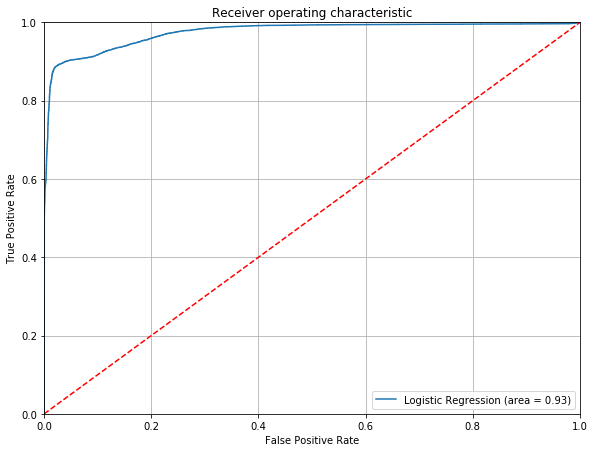

In [166]:
logit_roc_auc = roc_auc_score(y_test, logit.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logit.predict_proba(X_test)[:,1])
plt.figure(figsize = (9.6, 7.2))
plt.grid()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

- According to the graph above, the AUC Our logistic regression classifier is close enough to 1 to make our classifier a great one.

## Conclusion

We got a simple logistic regression classifier that not only satisfies all our conditions in problem statement, but also performs well.